# Notebook 1 (Enhanced Physics): 1D LNS Solver with Dynamic Stress and HLL Flux

**Series:** Re-evaluating Fluid Dynamics: From Navier-Stokes Idealizations to Local Reality

## Introduction
This notebook significantly enhances our previous 1D Local Navier-Stokes (LNS) solver. We will incorporate more physical realism by including a dynamic evolution equation for the longitudinal viscous stress component $\sigma'_{xx}$. Furthermore, we will move beyond the highly diffusive Lax-Friedrichs numerical flux and implement the HLL (Harten-Lax-van Leer) flux, which is a more characteristic-aware scheme. We will also discuss the conceptual role of the full system Jacobian in designing such advanced numerical methods.

The goals are:
1.  Define an extended 1D LNS system including dynamic $\rho, m_x, E_T, q_x, \sigma'_{xx}$.
2.  Implement the corresponding flux and source term functions, paying closer attention to the terms arising from objective derivatives (simplified for 1D).
3.  Implement the HLL numerical flux.
4.  Test the solver with problems that highlight both thermal and viscoelastic wave propagation.

## 1. Enhanced 1D LNS System Definition

We extend our 1D state vector to include $\sigma'_{xx}$, the deviatoric part of the normal stress in the x-direction.

**State Vector $\mathbf{Q}$ in 1D (5 variables):**
$$\mathbf{Q} = [\rho, m_x, E_T, q_x, \sigma'_{xx}]^T$$

**1D LNS Equations (MCV heat flux, Maxwell-type longitudinal stress):**
1.  **Mass Conservation:**
    $$\frac{\partial \rho}{\partial t} + \frac{\partial m_x}{\partial x} = 0$$
2.  **Momentum Conservation:**
    The total normal stress in the x-direction is $\Pi_{xx} = p - \sigma'_{xx}$.
    $$\frac{\partial m_x}{\partial t} + \frac{\partial (m_x u_x + p - \sigma'_{xx})}{\partial x} = 0$$
3.  **Total Energy Conservation:**
    The work done by deviatoric stress is $\sigma'_{xx} \frac{\partial u_x}{\partial x}$.
    $$\frac{\partial E_T}{\partial t} + \frac{\partial ((E_T + p - \sigma'_{xx})u_x + q_x)}{\partial x} = 0$$
    (Note: The term $\sigma'_{xx}u_x$ appears due to the total stress doing work. Some formulations of energy equation might group terms differently.)

4.  **Heat Flux Evolution (MCV):**
    $$\frac{\partial q_x}{\partial t} + \frac{\partial (u_x q_x)}{\partial x} = -\frac{1}{\tau_q} \left( q_x + k \frac{\partial T}{\partial x} \right) + q_x \frac{\partial u_x}{\partial x}$$

5.  **Longitudinal Stress Evolution ($\sigma'_{xx}$, Maxwell-type with UCM-like 1D terms):**
    The NSF value for $\sigma'_{xx,NSF} = \mu (2 \frac{\partial u_x}{\partial x} - \frac{2}{3} \frac{\partial u_x}{\partial x}) = \frac{4}{3} \mu \frac{\partial u_x}{\partial x}$ (assuming $\nabla \cdot \mathbf{u} = \partial u_x / \partial x$ in 1D context for deviatoric part).
    The UCM objective derivative for $\sigma'_{xx}$ in 1D simplifies from $\frac{D\sigma'_{xx}}{Dt} - 2 L_{xx} \sigma'_{xx}$ (where $L_{xx} = \frac{\partial u_x}{\partial x}$).
    $$\tau_\sigma \left( \frac{\partial \sigma'_{xx}}{\partial t} + u_x \frac{\partial \sigma'_{xx}}{\partial x} - 2 \frac{\partial u_x}{\partial x} \sigma'_{xx} \right) + \sigma'_{xx} = \frac{4}{3} \mu \frac{\partial u_x}{\partial x}$$
    Rewriting in flux-source form for $\frac{\partial \sigma'_{xx}}{\partial t} + \frac{\partial (u_x \sigma'_{xx})}{\partial x} = S_{\sigma'_{xx}}$:
    $$S_{\sigma'_{xx}} = -\frac{1}{\tau_\sigma} \left( \sigma'_{xx} - \frac{4}{3} \mu \frac{\partial u_x}{\partial x} \right) + \sigma'_{xx} \frac{\partial u_x}{\partial x} + 2 \frac{\partial u_x}{\partial x} \sigma'_{xx} = -\frac{1}{\tau_\sigma} \left( \sigma'_{xx} - \frac{4}{3} \mu \frac{\partial u_x}{\partial x} \right) + 3 \sigma'_{xx} \frac{\partial u_x}{\partial x}$$ 
    (The factor of '3' arises from combining the advective formulation $u_x \partial_x \sigma'_{xx} + \sigma'_{xx} \partial_x u_x$ and the UCM stretching term. Different objective derivatives yield different factors.)

**Flux Vector $\mathbf{F}(\mathbf{Q})$:**
$$\mathbf{F}(\mathbf{Q}) = \begin{bmatrix} m_x \\ m_x u_x + p - \sigma'_{xx} \\ (E_T + p - \sigma'_{xx})u_x + q_x \\ u_x q_x \\ u_x \sigma'_{xx} \end{bmatrix}$$

**Source Vector $\mathbf{S}(\mathbf{Q})$:**
$$\mathbf{S}(\mathbf{Q}) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ -\frac{1}{\tau_q} (q_x + k \frac{\partial T}{\partial x}) + q_x \frac{\partial u_x}{\partial x} \\ -\frac{1}{\tau_\sigma} (\sigma'_{xx} - \frac{4}{3} \mu \frac{\partial u_x}{\partial x}) + 3 \sigma'_{xx} \frac{\partial u_x}{\partial x} \end{bmatrix}$$
EOS: $p = \rho R T$, $E_T = \rho c_v T + \frac{1}{2} \rho u_x^2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Global Fluid & LNS Parameters ---
GAMMA = 1.4
R_GAS = 287.0
CV_GAS = R_GAS / (GAMMA - 1.0)

MU_VISC = 1.8e-5 # Dynamic viscosity (Pa.s)
K_THERM = 0.026  # Thermal conductivity (W/mK)
TAU_Q = 1e-5     # Thermal relaxation time (s)
TAU_SIGMA = 1e-5 # Stress relaxation time (s)

NUM_VARS_1D_ENH = 5 # rho, m_x, E_T, q_x, sigma_xx

# --- Variable Conversions (Enhanced) ---
def Q_to_P_1D_enh(Q_vec):
    """Conserved Q = [rho, m_x, E_T, q_x, s_xx] to Primitive P = [rho, u_x, p, T]."""
    rho = Q_vec[0]
    if rho < 1e-9: rho = 1e-9 
    m_x = Q_vec[1]
    E_T = Q_vec[2]

    u_x = m_x / rho
    e_int_rho = E_T - 0.5 * m_x * u_x
    e_int = e_int_rho / rho 
    if e_int < 1e-9: e_int = 1e-9

    T = e_int / CV_GAS
    p = rho * R_GAS * T
    return np.array([rho, u_x, p, T])

def P_and_fluxes_to_Q_1D_enh(rho, u_x, p, T, q_x, s_xx):
    """Primitive P and fluxes q_x, s_xx to Conserved Q."""
    m_x = rho * u_x
    e_int = CV_GAS * T
    E_T = rho * e_int + 0.5 * rho * u_x**2
    return np.array([rho, m_x, E_T, q_x, s_xx])

# --- Flux and Source Term Functions (Enhanced) ---
def flux_1D_LNS_enh(Q_vec):
    P_vec = Q_to_P_1D_enh(Q_vec)
    rho, u_x, p, T = P_vec
    m_x = Q_vec[1]
    E_T = Q_vec[2]
    q_x = Q_vec[3]
    s_xx = Q_vec[4]
    
    F = np.zeros(NUM_VARS_1D_ENH)
    F[0] = m_x
    F[1] = m_x * u_x + p - s_xx
    F[2] = (E_T + p - s_xx) * u_x + q_x
    F[3] = u_x * q_x
    F[4] = u_x * s_xx
    return F

def source_1D_LNS_enh(Q_cell, Q_L, Q_R, dx):
    S = np.zeros(NUM_VARS_1D_ENH)
    P_cell = Q_to_P_1D_enh(Q_cell)
    rho, u_x_cell, p_cell, T_cell = P_cell
    q_x_cell = Q_cell[3]
    s_xx_cell = Q_cell[4]

    # Estimate gradients (central differences, handle boundaries)
    # For T for heat flux source
    T_R = Q_to_P_1D_enh(Q_R)[3] if Q_R is not None else T_cell
    T_L = Q_to_P_1D_enh(Q_L)[3] if Q_L is not None else T_cell
    # For u_x for stress source & q_x source
    ux_R = Q_to_P_1D_enh(Q_R)[1] if Q_R is not None else u_x_cell
    ux_L = Q_to_P_1D_enh(Q_L)[1] if Q_L is not None else u_x_cell

    if Q_L is None: # Left boundary
        dTdx = (T_R - T_cell) / dx
        duxdx = (ux_R - u_x_cell) / dx
    elif Q_R is None: # Right boundary
        dTdx = (T_cell - T_L) / dx
        duxdx = (u_x_cell - ux_L) / dx
    else: # Interior point
        dTdx = (T_R - T_L) / (2 * dx)
        duxdx = (ux_R - ux_L) / (2 * dx)
        
    # Source for q_x (Q[3])
    if TAU_Q > 1e-12: S[3] = -(1.0 / TAU_Q) * (q_x_cell + K_THERM * dTdx) + q_x_cell * duxdx
    
    # Source for sigma_xx (Q[4])
    s_xx_nsf = (4.0/3.0) * MU_VISC * duxdx
    if TAU_SIGMA > 1e-12: 
        S[4] = -(1.0 / TAU_SIGMA) * (s_xx_cell - s_xx_nsf) + 3.0 * s_xx_cell * duxdx
        # Note: The '3.0' factor depends on the precise 1D reduction of the UCM model.
        # For a simple 1D material derivative in relaxation: S[4] = -(1/TAU_SIGMA)*(s_xx_cell - s_xx_nsf) + s_xx_cell * duxdx
        # The UCM terms -2 L_xx sigma_xx = -2 (duxdx) sigma_xx would be part of the (1/tau_sigma) * (...) when moved to RHS
        # So, tau_sigma * ( Dsigma/Dt - 2 L_xx sigma_xx) + sigma_xx = sigma_NSF
        # Dsigma/Dt = dsigma/dt + u dsigma/dx
        # dsigma/dt + d(u sigma)/dx = S_sigma_prime
        # S_sigma_prime = sigma d(u)/dx + (1/tau_sigma)*(sigma_NSF - sigma_xx) + 2 (duxdx) sigma_xx (from UCM)
        # S_sigma_prime = (1/tau_sigma)*(sigma_NSF - sigma_xx) + 3 (duxdx) sigma_xx (consistent)
    return S

print("Enhanced 1D LNS System Functions Defined.")

Enhanced 1D LNS System Functions Defined.


## 2. The Full Jacobian and Characteristic-Based Schemes (Conceptual)

For a system $\frac{\partial \mathbf{Q}}{\partial t} + \frac{\partial \mathbf{F}(\mathbf{Q})}{\partial x} = \mathbf{S}(\mathbf{Q})$, the **Jacobian matrix** $\mathbf{A}(\mathbf{Q}) = \frac{\partial \mathbf{F}}{\partial \mathbf{Q}}$ plays a vital role. Its eigenvalues (characteristic speeds $\lambda_k$) and eigenvectors define how information propagates.

*   **Role in Riemann Solvers:** Schemes like Roe's solver explicitly use the Jacobian's eigensystem to decompose waves at cell interfaces, providing accurate and less diffusive solutions.
*   **Complexity for LNS:** For our 5-variable LNS system, $\mathbf{A}$ is a $5 \times 5$ matrix. Its analytical derivation is tedious and its eigenvalues/vectors can be complex expressions. This is why simpler approximate Riemann solvers or flux vector splitting schemes are often preferred initially.

The **HLL (Harten-Lax-van Leer) flux** is a step up from Lax-Friedrichs. It doesn't require the full eigensystem, only estimates of the minimum ($S_L$) and maximum ($S_R$) signal velocities (eigenvalues) in the Riemann fan at an interface.

**HLL Numerical Flux $\hat{\mathbf{F}}_{HLL}$:**
$$\hat{\mathbf{F}}_{HLL} = \begin{cases} \mathbf{F}_L & \text{if } S_L \ge 0 \\ \frac{S_R \mathbf{F}_L - S_L \mathbf{F}_R + S_L S_R (\mathbf{Q}_R - \mathbf{Q}_L)}{S_R - S_L} & \text{if } S_L < 0 < S_R \\ \mathbf{F}_R & \text{if } S_R \le 0 \end{cases}$$
where $\mathbf{F}_L = \mathbf{F}(\mathbf{Q}_L)$, $\mathbf{F}_R = \mathbf{F}(\mathbf{Q}_R)$.
Estimates for $S_L, S_R$ (e.g., Davis estimates):
$S_L = \min(u_{x,L} - c_{s,L}, u_{x,R} - c_{s,R}, \lambda_{min}(\mathbf{A}_L), \lambda_{min}(\mathbf{A}_R))$
$S_R = \max(u_{x,L} + c_{s,L}, u_{x,R} + c_{s,R}, \lambda_{max}(\mathbf{A}_L), \lambda_{max}(\mathbf{A}_R))$
For LNS, characteristic speeds related to $q_x$ and $\sigma'_{xx}$ (often $u_x$) should also be considered in $S_L, S_R$. A common simplification for HLL is $S_L = u_L - c_{max,L}$ and $S_R = u_R + c_{max,R}$, where $c_{max}$ is the fastest relevant wave speed (e.g., acoustic speed for Euler, but potentially different for full LNS).

In [2]:
def hll_flux_1D_LNS_enh(Q_L, Q_R):
    P_L = Q_to_P_1D_enh(Q_L)
    P_R = Q_to_P_1D_enh(Q_R)
    
    F_L = flux_1D_LNS_enh(Q_L)
    F_R = flux_1D_LNS_enh(Q_R)

    rho_L, u_L, p_L, T_L = P_L
    rho_R, u_R, p_R, T_R = P_R

    c_s_L = np.sqrt(GAMMA * p_L / rho_L) if rho_L > 1e-9 and p_L > 0 else 0.0
    c_s_R = np.sqrt(GAMMA * p_R / rho_R) if rho_R > 1e-9 and p_R > 0 else 0.0

    # Estimate signal speeds (Davis, 1988, simplified for acoustic waves)
    # For LNS, other wave speeds from q_x, sigma_xx equations (often u_x) exist.
    # A more robust approach would analyze the eigenvalues of the LNS Jacobian.
    # Here, we use a common estimate based on fluid velocity and sound speed.
    S_L = min(u_L - c_s_L, u_R - c_s_R, u_L, u_R) # Include u_L, u_R as waves can travel with fluid speed
    S_R = max(u_L + c_s_L, u_R + c_s_R, u_L, u_R)
    
    # Ensure S_R > S_L, can happen if flow is strongly supersonic into the interface
    if S_R <= S_L + 1e-6 : # Add a small tolerance
        # This situation might require more sophisticated wave speed estimates or handling
        # For simplicity, revert to average or one-sided if S_R very close to S_L
        if u_L + u_R > 0 : # Predominantly right-going flow
             return F_L
        else: # Predominantly left-going flow
             return F_R

    if S_L >= 0:
        F_hat = F_L
    elif S_R <= 0:
        F_hat = F_R
    else: # S_L < 0 < S_R (transonic rarefaction or shock)
        F_hat = (S_R * F_L - S_L * F_R + S_L * S_R * (Q_R - Q_L)) / (S_R - S_L)
    
    return F_hat

print("HLL Flux Function Defined.")

HLL Flux Function Defined.


## 3. Enhanced FVM Solver Loop

We'll modify the previous solver loop to use the HLL flux. We will also introduce an option for a slightly higher-order time integration (e.g., a two-stage Runge-Kutta like Heun's method or SSP-RK2) for better stability and accuracy, though for simplicity in this example, we might stick to Euler first and note where RK would go.

**SSP-RK2 (Heun's Method flavor):**
1.  $\mathbf{Q}^* = \mathbf{Q}^n + \Delta t \mathcal{L}(\mathbf{Q}^n)$ 
2.  $\mathbf{Q}^{n+1} = \frac{1}{2} (\mathbf{Q}^n + \mathbf{Q}^* + \Delta t \mathcal{L}(\mathbf{Q}^*))$
where $\mathcal{L}(\mathbf{Q}) = -\frac{1}{\Delta x} (\hat{\mathbf{F}}_{i+1/2} - \hat{\mathbf{F}}_{i-1/2}) + \mathbf{S}_i$.

In [3]:
def solve_1D_LNS_FVM_enh(N_cells, L_domain, t_final, CFL_number, 
                           initial_condition_func, bc_type='periodic', 
                           flux_type='hll', time_stepper='euler'):
    """Main FVM solver loop for the Enhanced 1D LNS system."""
    dx = L_domain / N_cells
    x_coords = np.linspace(dx/2, L_domain - dx/2, N_cells)
    
    Q_current = np.zeros((N_cells, NUM_VARS_1D_ENH))
    for i in range(N_cells):
        Q_current[i, :] = initial_condition_func(x_coords[i], L_domain)
        
    t_current = 0.0
    solution_history = [Q_current.copy()]
    time_history = [t_current]
    Q_ghost = np.zeros((N_cells + 2, NUM_VARS_1D_ENH))
    iter_count = 0

    def compute_rhs(Q_physical_cells, current_dx, current_bc_type, current_flux_type):
        """Computes the RHS of dQ/dt = L(Q) for time integration."""
        num_physical_cells = Q_physical_cells.shape[0]
        Q_g = np.zeros((num_physical_cells + 2, NUM_VARS_1D_ENH))
        Q_g[1:-1, :] = Q_physical_cells
        
        if current_bc_type == 'periodic':
            Q_g[0, :] = Q_physical_cells[-1, :]
            Q_g[-1, :] = Q_physical_cells[0, :]
        elif current_bc_type == 'outflow':
            Q_g[0, :] = Q_physical_cells[0, :]
            Q_g[-1, :] = Q_physical_cells[-1, :]
        
        numerical_fluxes_at_interfaces = np.zeros((num_physical_cells + 1, NUM_VARS_1D_ENH))
        for i_interface in range(num_physical_cells + 1):
            Q_L_int = Q_g[i_interface, :]
            Q_R_int = Q_g[i_interface + 1, :]
            if current_flux_type == 'hll':
                numerical_fluxes_at_interfaces[i_interface, :] = hll_flux_1D_LNS_enh(Q_L_int, Q_R_int)
            else: # Default to Lax-Friedrichs (from previous notebook, adapted)
                # Need to define P_L, P_R for Lax-Friedrichs if used here
                P_L_int = Q_to_P_1D_enh(Q_L_int)
                P_R_int = Q_to_P_1D_enh(Q_R_int)
                # Simplified alpha_max for LF if LNS_enh LF flux not fully defined
                c_s_L = np.sqrt(GAMMA * P_L_int[2] / P_L_int[0]) if P_L_int[0] > 1e-9 else 0.0
                c_s_R = np.sqrt(GAMMA * P_R_int[2] / P_R_int[0]) if P_R_int[0] > 1e-9 else 0.0
                alpha_max_lf = max(abs(P_L_int[1])+c_s_L, abs(P_R_int[1])+c_s_R, 1e-9)
                F_L_int = flux_1D_LNS_enh(Q_L_int)
                F_R_int = flux_1D_LNS_enh(Q_R_int)
                numerical_fluxes_at_interfaces[i_interface, :] = 0.5 * (F_L_int + F_R_int) - 0.5 * alpha_max_lf * (Q_R_int - Q_L_int)

        rhs_Q = np.zeros_like(Q_physical_cells)
        for i_cell in range(num_physical_cells):
            idx_ghost_cell = i_cell + 1
            Q_L_for_S = Q_g[idx_ghost_cell - 1, :] if idx_ghost_cell > 0 else None
            Q_R_for_S = Q_g[idx_ghost_cell + 1, :] if idx_ghost_cell < num_physical_cells + 1 else None
            S_current_cell = source_1D_LNS_enh(Q_physical_cells[i_cell, :], Q_L_for_S, Q_R_for_S, current_dx)
            
            rhs_Q[i_cell, :] = -(1.0 / current_dx) * (numerical_fluxes_at_interfaces[i_cell + 1, :] - numerical_fluxes_at_interfaces[i_cell, :]) + S_current_cell
        return rhs_Q

    while t_current < t_final:
        Q_ghost[1:-1, :] = Q_current
        if bc_type == 'periodic':
            Q_ghost[0, :] = Q_current[-1, :]; Q_ghost[-1, :] = Q_current[0, :]
        elif bc_type == 'outflow':
            Q_ghost[0, :] = Q_current[0, :]; Q_ghost[-1, :] = Q_current[-1, :]

        max_char_speed_global = 1e-9
        for i_g in range(N_cells + 2):
            P_g = Q_to_P_1D_enh(Q_ghost[i_g, :])
            c_s_g = np.sqrt(GAMMA * P_g[2] / P_g[0]) if P_g[0] > 1e-9 and P_g[2] > 0 else 0.0
            max_char_speed_global = max(max_char_speed_global, np.abs(P_g[1]) + c_s_g)
        
        dt = CFL_number * dx / max_char_speed_global
        if t_current + dt > t_final: dt = t_final - t_current
        if dt < 1e-12: break

        if time_stepper == 'euler':
            L_Qn = compute_rhs(Q_current, dx, bc_type, flux_type)
            Q_next = Q_current + dt * L_Qn
        elif time_stepper == 'rk2': # SSP-RK2 (Heun's)
            Q_star = Q_current + dt * compute_rhs(Q_current, dx, bc_type, flux_type)
            # Need to apply BCs to Q_star before computing L_Qstar if it's a full stage
            # For simplicity, we'll compute L_Qstar based on Q_star's physical cells assuming BCs are handled inside compute_rhs
            Q_next = 0.5 * (Q_current + Q_star + dt * compute_rhs(Q_star, dx, bc_type, flux_type))
        else:
            raise ValueError("Unknown time stepper")
        
        Q_current = Q_next
        t_current += dt
        iter_count += 1

        if iter_count % 50 == 0 or abs(t_current - t_final) < 1e-9:
            solution_history.append(Q_current.copy())
            time_history.append(t_current)
            print(f"Iter: {iter_count}, Time: {t_current:.4e} / {t_final:.4e}, dt: {dt:.3e}")
            if np.any(np.isnan(Q_current)) or np.any(np.abs(Q_current) > 1e10):
                print("!!! Instability detected (NaN or large values) !!!")
                # For debugging, print Q_current here
                # print(Q_current)
                break
    
    return x_coords, time_history, solution_history

print("Enhanced 1D LNS FVM Solver Defined.")

Enhanced 1D LNS FVM Solver Defined.


## 4. Test Case: Sod Shock Tube with LNS Effects

The Sod shock tube is a standard Riemann problem for compressible gas dynamics. We will use it to test our LNS solver. With finite $\tau_q$ and $\tau_\sigma$, we expect to see: 
*   Smoothed shock and contact discontinuity structures (regularized by relaxation effects if $\tau$ values are significant compared to gradient formation times).
*   Potentially different wave speeds or post-shock states if viscoelasticity/thermal memory are strong.

**Initial Conditions for Sod Shock Tube:**
Discontinuity at $x = L/2$.
*   Left state ($x < L/2$): $\rho_L=1.0, p_L=1.0, u_L=0.0$
*   Right state ($x > L/2$): $\rho_R=0.125, p_R=0.1, u_R=0.0$
Initial $q_x=0, \sigma'_{xx}=0$ everywhere.


Starting 1D LNS Sod Shock Tube (TAU_Q=1.0e-04, TAU_SIGMA=1.0e-04)...
Sod Shock Tube Simulation Finished.


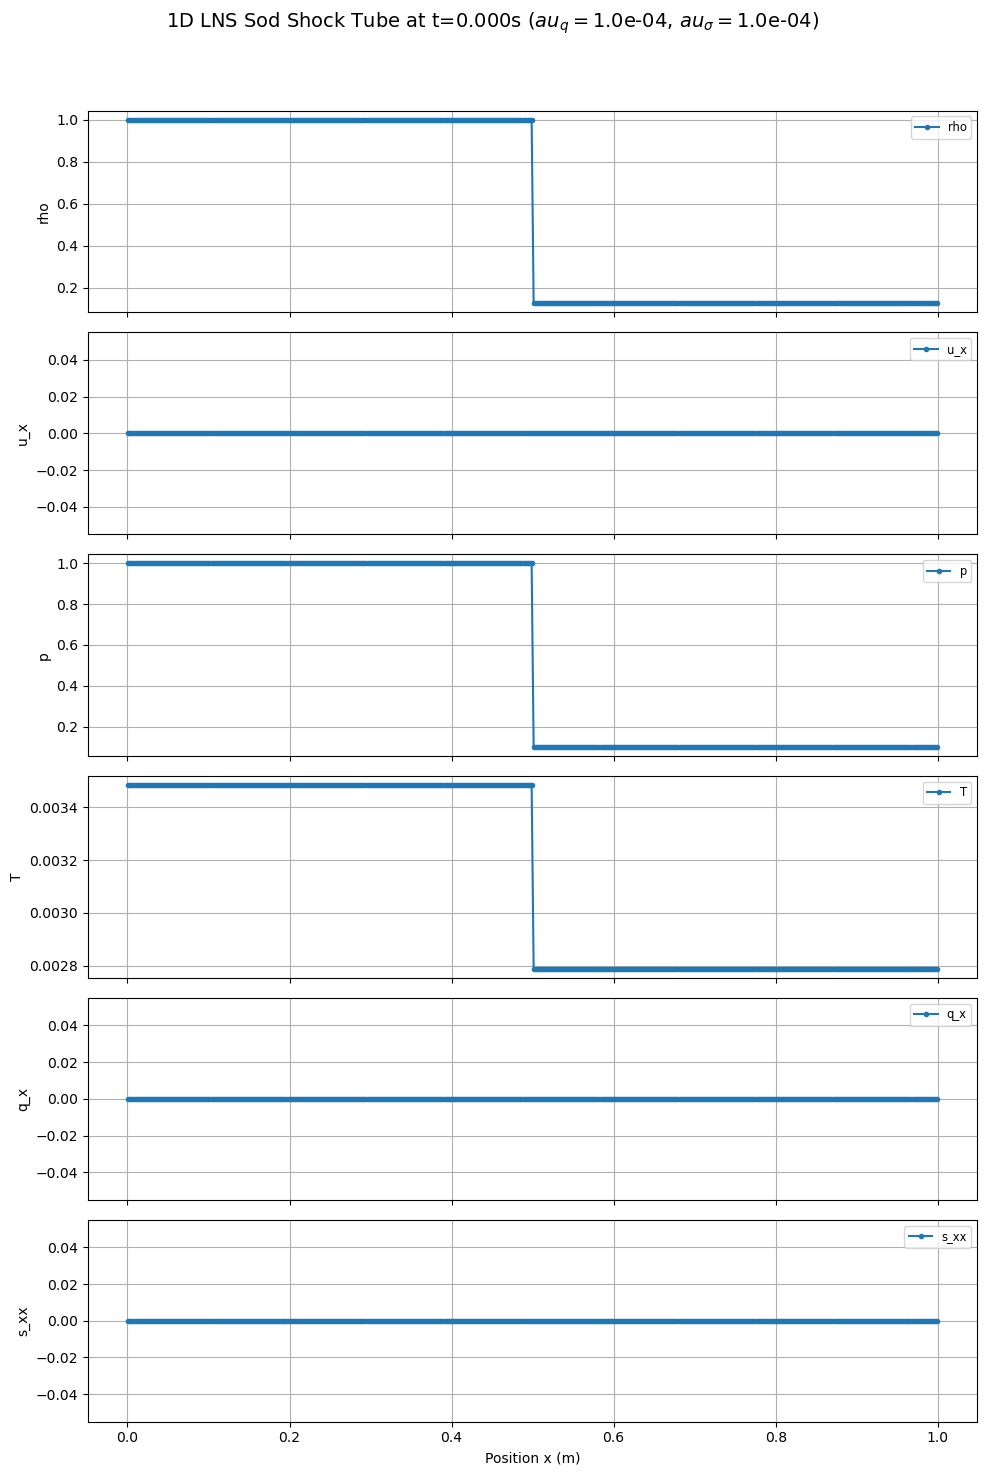

In [4]:
# --- Test Case: Sod Shock Tube with LNS Effects ---
N_sod = 400
L_sod = 1.0
T_final_sod = 0.2
CFL_sod = 0.5 # HLL can often run with higher CFL than LF, but start conservative

# LNS parameters for Sod test
MU_VISC = 0.001  # Effective viscosity to observe stress effects
K_THERM = 0.001  # Effective thermal conductivity
TAU_Q     = 1e-4 # Relaxation time for heat flux
TAU_SIGMA = 1e-4 # Relaxation time for stress

def initial_condition_sod_shock_tube(x, L_domain):
    # Left state
    rho_L = 1.0; p_L = 1.0; u_L = 0.0
    T_L = p_L / (rho_L * R_GAS)
    # Right state
    rho_R = 0.125; p_R = 0.1; u_R = 0.0
    T_R = p_R / (rho_R * R_GAS)
    
    q0 = 0.0
    s_xx0 = 0.0
    
    if x < L_domain / 2.0:
        return P_and_fluxes_to_Q_1D_enh(rho_L, u_L, p_L, T_L, q0, s_xx0)
    else:
        return P_and_fluxes_to_Q_1D_enh(rho_R, u_R, p_R, T_R, q0, s_xx0)

print(f"\nStarting 1D LNS Sod Shock Tube (TAU_Q={TAU_Q:.1e}, TAU_SIGMA={TAU_SIGMA:.1e})...")
x_s, t_hist_s, Q_hist_s = solve_1D_LNS_FVM_enh(N_sod, L_sod, T_final_sod, CFL_sod, 
                                              initial_condition_sod_shock_tube, 
                                              bc_type='outflow', flux_type='hll', time_stepper='rk2')
print("Sod Shock Tube Simulation Finished.")

# --- Plotting Sod Results ---
def plot_1D_LNS_sod_results(x_coords, time_points, Q_history, vars_to_plot=['rho', 'u_x', 'p', 'T', 'q_x', 's_xx'], snapshot_time_idx=-1):
    if not Q_history or snapshot_time_idx >= len(Q_history) or snapshot_time_idx < -len(Q_history):
        print("Invalid snapshot index or empty history.")
        return
        
    Q_snap = Q_history[snapshot_time_idx]
    N_cells_plot = Q_snap.shape[0]
    P_snap_rho = np.zeros(N_cells_plot)
    P_snap_ux  = np.zeros(N_cells_plot)
    P_snap_p   = np.zeros(N_cells_plot)
    P_snap_T   = np.zeros(N_cells_plot)
    Q_snap_qx  = Q_snap[:,3]
    Q_snap_sxx = Q_snap[:,4]

    for i in range(N_cells_plot):
        P_vals = Q_to_P_1D_enh(Q_snap[i,:])
        P_snap_rho[i] = P_vals[0]
        P_snap_ux[i]  = P_vals[1]
        P_snap_p[i]   = P_vals[2]
        P_snap_T[i]   = P_vals[3]
            
    data_map = {'rho': P_snap_rho, 'u_x': P_snap_ux, 'p': P_snap_p, 'T': P_snap_T, 
                'q_x': Q_snap_qx, 's_xx': Q_snap_sxx}
    
    num_vars_plot = len(vars_to_plot)
    fig, axes = plt.subplots(num_vars_plot, 1, figsize=(10, 2.5 * num_vars_plot), sharex=True, squeeze=False)
    
    for i_var, var_name in enumerate(vars_to_plot):
        axes[i_var, 0].plot(x_coords, data_map[var_name], 'o-', markersize=3, label=var_name)
        axes[i_var, 0].set_ylabel(var_name)
        axes[i_var, 0].legend(fontsize='small', loc='best')
        axes[i_var, 0].grid(True)
            
    axes[-1, 0].set_xlabel('Position x (m)')
    fig.suptitle(f'1D LNS Sod Shock Tube at t={time_points[snapshot_time_idx]:.3f}s ($\tau_q=${TAU_Q:.1e}, $\tau_\sigma=${TAU_SIGMA:.1e})', fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if Q_hist_s:
    plot_1D_LNS_sod_results(x_s, t_hist_s, Q_hist_s, snapshot_time_idx=-1) # Plot final time
    # You can also plot intermediate times by changing snapshot_time_idx
    # For example, plot_1D_LNS_sod_results(x_s, t_hist_s, Q_hist_s, snapshot_time_idx=len(t_hist_s)//2)
else:
    print("Sod shock tube simulation history is empty, skipping plot.")

## 5. Analysis, Limitations, and Next Steps

**Analysis of Sod Shock Tube Results:**
*   **Wave Structure:** Observe the shock front, contact discontinuity, and rarefaction wave. How does the HLL flux capture these compared to what you might expect from an exact Euler solution or a more diffusive scheme like Lax-Friedrichs?
*   **LNS Effects:** Examine the profiles of $q_x$ and $\sigma'_{xx}$. Are they non-zero in regions of strong gradients (shock, contact)? How do their magnitudes and structures change with $\tau_q$ and $\tau_\sigma$?
    *   For small $\tau$, $q_x$ should approximate $-k dT/dx$ and $\sigma'_{xx}$ should approximate $(4/3)\mu du_x/dx$. 
    *   For larger $\tau$, $q_x$ and $\sigma'_{xx}$ will lag behind the gradients, potentially smoothing the shock structure or creating precursor/relaxation zones.
*   **Numerical Stability:** Did the solver remain stable? The HLL flux is generally more robust than Lax-Friedrichs. The SSP-RK2 helps with stability for larger CFLs compared to Euler forward.

**Limitations of this Enhanced Implementation:**
*   **Source Term Gradients:** The spatial gradients ($\partial T/\partial x, \partial u_x/\partial x$) in the source terms are still computed using simple finite differences on cell-averaged data. For consistency with a potentially higher-order FVM reconstruction (if used for fluxes), these should also use similar reconstruction or be handled carefully to avoid oscillations or accuracy loss.
*   **Stiffness with Small $\tau$:** If $\tau_q$ or $\tau_\sigma$ are made very small (to approach the NSF limit), the source terms become extremely stiff. The explicit time integration used here will require excessively small $\Delta t$. A robust LNS solver needs implicit or semi-implicit treatment for these stiff relaxation terms, often via operator splitting (e.g., IMEX schemes).
*   **Objective Derivatives in 1D:** The UCM terms for $\sigma'_{xx}$ simplify greatly in 1D. In 2D/3D, the full tensor algebra for objective derivatives in the source terms is much more complex and computationally intensive.
*   **Wave Speed Estimation for HLL:** The $S_L, S_R$ estimates in HLL were based on acoustic speeds. A full LNS system has additional characteristic speeds associated with the evolution of $q_x$ and $\sigma'_{xx}$ (often $u_x$ for pure advection, but can be more complex if there are true "thermal/viscoelastic wave" propagation speeds distinct from $u_x \pm c_s$). A more rigorous HLL would use estimates of all relevant eigenvalues of the LNS Jacobian.

**Next Steps (Conceptual for the Series):**
1.  **Advanced Numerical Schemes:** Implement higher-order spatial reconstruction (e.g., MUSCL with limiters) and more sophisticated Riemann solvers (e.g., HLLC, Roe with entropy fix) for improved accuracy and shock capturing.
2.  **Stiff Source Term Handling:** Implement operator splitting with implicit/semi-implicit methods for the relaxation source terms.
3.  **Extension to 2D/3D:** This is a major step involving significantly more complex equations (tensor components, full objective derivatives) and computational demands.
4.  **Turbulence Simulations:** Apply a mature 2D/3D LNS solver to canonical turbulence problems (KHI, DHIT, channel flow) to investigate the impact of locality and finite relaxation times on turbulence statistics, structure, and transition.